In [ ]:
from huggingface_hub import notebook_login
access_token = ""

notebook_login()

In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
from datasets import load_dataset, ClassLabel

dataset = load_dataset("Sri3010/Audio_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 438
    })
})

In [ ]:
(dataset['train'][300])

{'audio': {'path': '/root/.cache/huggingface/hub/datasets--Sri3010--Audio_dataset/snapshots/f3422560ba77364bbf9ba8115b950ccee8a55db5/collected data/Telangan/Telangana (114).wav',
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'label': 4}

In [ ]:
from datasets import DatasetDict

# Split the dataset into train (80%) and temp (20%)
train_test_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
temp_dataset = train_test_split["test"]

# Further split temp dataset into validation (10%) and test (10%)
validation_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = validation_test_split["train"]
test_dataset = validation_test_split["test"]

# Create the final DatasetDict
final_dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

# Display the splits
print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 350
    })
    validation: Dataset({
        features: ['audio', 'label'],
        num_rows: 44
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 44
    })
})


In [ ]:
labels = ["Chennai tamil", "Coastal Andhra", "Kongu tamil", "Rayalaseema", "Telangana", "Tirunelveli tamil"]

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["2"]

'Kongu tamil'

In [ ]:
dataset = final_dataset

In [ ]:
from transformers import AutoFeatureExtractor

model_id = "openai/whisper-tiny"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True
)

In [ ]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [ ]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [ ]:
max_duration = 30

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

In [ ]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns="audio",
    batched=True,
    batch_size=2,
    num_proc=1,
)
dataset_encoded

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_features'],
        num_rows: 350
    })
    validation: Dataset({
        features: ['label', 'input_features'],
        num_rows: 44
    })
    test: Dataset({
        features: ['label', 'input_features'],
        num_rows: 44
    })
})

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['model.classifier.bias', 'model.classifier.weight', 'model.projector.bias', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 2 # This affects your GPU VRAM requirements
gradient_accumulation_steps = 1
num_train_epochs = 10 # 10 seems the minimum for more than 5 classes

training_args = TrainingArguments(
    f"{model_name}-tel-tam-try1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset_encoded["train"].with_format("torch"),
    eval_dataset=dataset_encoded["test"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-24-6cc9991284ed>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700900,0.992192,0.522727
2,0.024000,0.272672,0.909091
3,0.410300,0.022302,1.000000
4,0.000800,0.190777,0.977273
5,0.000500,0.180216,0.977273
6,0.000500,0.182598,0.977273
7,0.000300,0.186820,0.977273
8,0.000200,0.190437,0.977273
9,0.000300,0.192511,0.977273
10,0.000200,0.193371,0.977273


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50

TrainOutput(global_step=1750, training_loss=0.20779798251982512, metrics={'train_runtime': 10337.2313, 'train_samples_per_second': 0.339, 'train_steps_per_second': 0.169, 'total_flos': 3.897172944e+16, 'train_loss': 0.20779798251982512, 'epoch': 10.0})

In [ ]:
kwargs = {
    #"dataset_tags": "speech_commands",
    "dataset": "Speech Commands",
    "model_name": f"{model_name}-tel-tam",
    "finetuned_from": model_id,
    "tasks": "audio-classification",
}a

In [ ]:
trainer.push_to_hub(**kwargs)


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50

events.out.tfevents.1737193499.9360ddab7e38.226.1:   0%|          | 0.00/84.4k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/JasHugF/whisper-tiny-tel-tam-try1/commit/bf325551c697ef02c9a656fcc7baf24fcaa66fff', commit_message='End of training', commit_description='', oid='bf325551c697ef02c9a656fcc7baf24fcaa66fff', pr_url=None, repo_url=RepoUrl('https://huggingface.co/JasHugF/whisper-tiny-tel-tam-try1', endpoint='https://huggingface.co', repo_type='model', repo_id='JasHugF/whisper-tiny-tel-tam-try1'), pr_revision=None, pr_num=None)

In [ ]:
# import sounddevice as sd
# import soundfile as sf

# duration = 2
# sr = 16000

# rec = sd.rec(int(duration) * sr, samplerate=sr, channels=1)
# sd.wait()

# sd.play(rec, samplerate=sr)

# audio_file_path = 'recorded_audio.wav'
# sf.write(audio_file_path, rec, sr)


In [ ]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="JasHugF/whisper-tiny-tel-tam-try1")


Device set to use cpu


In [ ]:
count = 0
for i in range(44):
    audio_file = final_dataset['test'][i]['audio']['path']
    actual_label = final_dataset['test'][i]['label']
    pred_label = classifier(audio_file)
    # print("Actual Label", actual_label)
    # print ("Predicted Label", label2id(pred_label[0]['label']))
    if int(actual_label) == int(label2id[pred_label[0]['label']]):
        count += 1
print("Accuracy", count/44)

KeyboardInterrupt: 

In [ ]:
audio_file = final_dataset['test'][0]['audio']['path']
actual_label = final_dataset['test'][0]['label']
pred_label = classifier(audio_file)


In [ ]:
audio_file = final_dataset['test'][5]['audio']['path']
actual_label = final_dataset['test'][5]['label']
pred_label = classifier(audio_file)


In [ ]:
print("Actual Label : ", id2label[str(actual_label)])
print ("""
[{'score': 0.9989122152328491, 'label': 'Coastal Andhra'},
{'score': 0.00039259775076061487, 'label': 'Telangana'},
{'score': 0.00023673885152675211, 'label': 'Chennai tamil'},
{'score': 0.0002330872230231762, 'label': 'Rayalaseema'},
{'score': 0.0001637216773815453, 'label': 'Tirunelveli tamil'}]
 """)
print ("Predicted Label : ", str(pred_label[0]['label']))

Actual Label :  Coastal Andhra

[{'score': 0.9989122152328491, 'label': 'Coastal Andhra'},
{'score': 0.00039259775076061487, 'label': 'Telangana'},
{'score': 0.00023673885152675211, 'label': 'Chennai tamil'},
{'score': 0.0002330872230231762, 'label': 'Rayalaseema'},
{'score': 0.0001637216773815453, 'label': 'Tirunelveli tamil'}]
 
Predicted Label :  Coastal Andhra


In [ ]:
print(pred_label)


[{'score': 0.9989122152328491, 'label': 'Coastal Andhra'}, {'score': 0.00039259775076061487, 'label': 'Telangana'}, {'score': 0.00023673885152675211, 'label': 'Chennai tamil'}, {'score': 0.0002330872230231762, 'label': 'Rayalaseema'}, {'score': 0.0001637216773815453, 'label': 'Tirunelveli tamil'}]


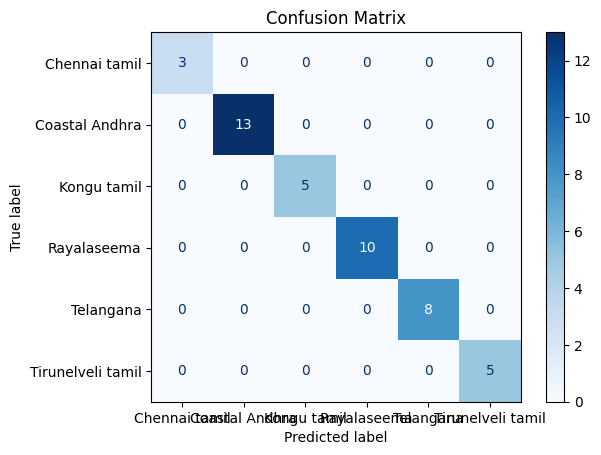

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare lists for actual and predicted labels
actual_labels = []
predicted_labels = []

for i in range(44):
    audio_file = final_dataset['test'][i]['audio']['path']
    actual_label = final_dataset['test'][i]['label']
    pred_label = classifier(audio_file)

    actual_labels.append(int(actual_label))
    predicted_labels.append(int(label2id[pred_label[0]['label']]))

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()